In [1]:
import os
import re
from types import SimpleNamespace
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import ipywidgets as widgets

os.environ.setdefault("KERAS_BACKEND", "torch")  # Use PyTorch backend unless specified otherwise

import keras
import numpy as np
import torch

keras.utils.set_random_seed(42)

from mnist import MNIST

# Neuron/Feature Visualization

In this notebook we will train simple neural network on MNIST dataset and visualize its neurons by using two methods:
- First Hidden Layer Neuron visualization
- Activation Maximization

## Training Neural Network

In this section we:
- load dataset
- define neural network architecture
- train the model
- save trained parameters

In [10]:
mnist = MNIST()
args = SimpleNamespace(batch_size=50, epochs=10, hidden_layer=128, learning_rate=1e-2,
                       learning_rate_final=1e-3)

In [11]:
model = keras.Sequential([
    keras.layers.Input(shape=[MNIST.H, MNIST.W, MNIST.C]),
    keras.layers.Rescaling(1 / 255),
    keras.layers.Flatten(),
    keras.layers.Dense(args.hidden_layer, activation="relu"),
    keras.layers.Dense(MNIST.LABELS, activation="softmax"),
])

max_steps = (mnist.train.size // args.batch_size) * args.epochs

learning_rate = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.learning_rate_final / args.learning_rate,
    decay_steps=max_steps
)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy("accuracy")],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# If the model is saved in filesystem - load it, otherwise train it and save.

if os.path.exists('model.weights.h5'):
    model.load_weights('model.weights.h5')
else:
    model.fit(
        mnist.train.data["images"], mnist.train.data["labels"],
        batch_size=args.batch_size, epochs=args.epochs,
        validation_data=(mnist.dev.data["images"], mnist.dev.data["labels"])
    )
    model.save_weights('model.weights.h5')

In [13]:
# Save trained parameters of the model.
params = [param.data.clone() for param in model.parameters()]
params

[tensor([[ 0.0188, -0.0531, -0.0275,  ..., -0.0293,  0.0531, -0.0326],
         [ 0.0408, -0.0645,  0.0625,  ...,  0.0544, -0.0456,  0.0718],
         [-0.0452,  0.0373,  0.0305,  ...,  0.0380,  0.0310,  0.0340],
         ...,
         [-0.0638, -0.0676,  0.0280,  ...,  0.0232, -0.0309, -0.0735],
         [-0.0235, -0.0638, -0.0497,  ..., -0.0683,  0.0726, -0.0394],
         [-0.0447, -0.0136,  0.0567,  ...,  0.0586, -0.0378,  0.0362]],
        device='cuda:0'),
 tensor([-0.2900, -0.0700,  0.0203,  0.0436, -0.0170, -0.2583,  0.3683, -0.1987,
         -0.0456, -0.2884, -0.0599, -0.0789,  0.0081, -0.4519, -0.0600, -0.0042,
          0.1422,  0.0932,  0.0295, -0.0599,  0.4157,  0.1814, -0.0599, -0.0137,
         -0.6069,  0.4647, -0.0476,  0.1774, -0.2244, -0.1014, -0.0739, -0.1043,
         -0.0599,  0.2158, -0.0722, -0.0385, -0.0738,  0.2654, -0.1365,  0.0305,
         -0.3626, -0.0375, -0.0632,  0.1315, -0.6022, -0.0475, -0.1004, -0.0119,
         -0.0598, -0.0685, -0.4184, -0.0599, -0

## First Hidden Layer Neuron Visualization

This is the most simple visualization. We choose a neuron from first hidden layer. This neuron has weighted connection to each input pixel of the image. Thus, we extract those weights and reshape them as an image. Getting visualization of which pixels contribute to highest neuron activation.

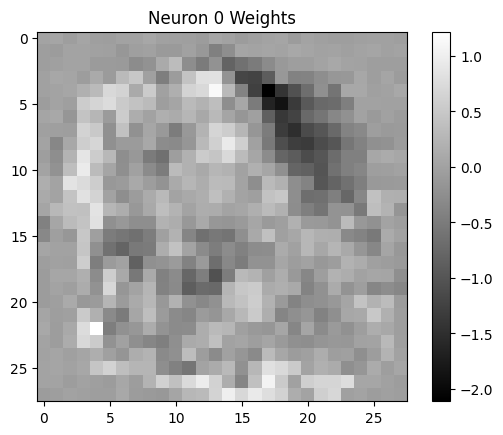

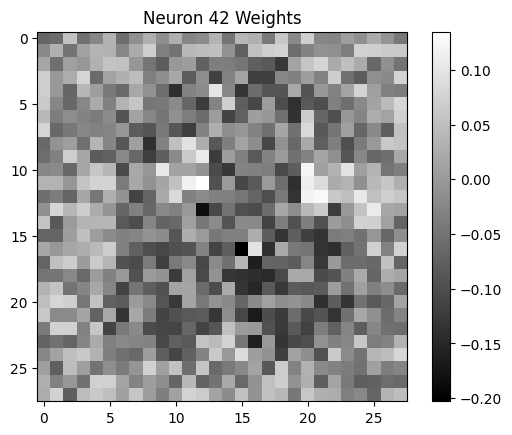

In [9]:
def get_ith_neuron_image(i):
    return params[0][:, i].reshape(28, 28).cpu().detach().numpy()


def visualize_ith_neuron(i):
    img = plt.imshow(get_ith_neuron_image(i), cmap='gray')
    plt.title(f'Neuron {i} Weights')
    plt.colorbar(img)
    plt.show()


visualize_ith_neuron(0)
visualize_ith_neuron(42)

## Activation Maximization

This approach is applicable not only for first hidden layer, but for any neuron or any collection of neurons across neural network.

In this method we train image to activate selected neurons with higher value - in other words, maximizing activation of selected neurons. 

We use gradient ascent to achieve that goal.

In [24]:
def train_nth_neuron_input(n, iterations=1000, report_after_iteration_number_of=200):
    # create input image variable
    input_img = keras.Variable(keras.random.normal(shape=[1, MNIST.H, MNIST.W, MNIST.C], seed=42), trainable=True)

    # initialize optimizer, feed it with tensors we want to train
    optimizer = torch.optim.Adam([input_img.value])

    for i in range(iterations):
        # zero out the gradients of watched tensors
        optimizer.zero_grad()

        # use models layers with its trained parameters
        # use flatten layer of the trained model architecture
        flattened = model.layers[1](input_img)
        # use dense layer of the trained model architecture with its trained weights and biases, get activations
        activations = model.layers[2](flattened)
        # select neuron/neurons, negating tensor to achieve gradient ascent and maximize activations instead of minimizing
        loss = -activations[0, n]
        # compute gradient of the loss
        loss.backward()
        # apply gradient using optimizer algorithm to the watched trained tensor
        optimizer.step()
        # report activation value
        if i % report_after_iteration_number_of == 0:
            print(f'Iteration: {i}; Activation: {activations[0, n]}')

    ax = plt.imshow(img, cmap='gray')
    plt.title(f'Neuron {n} Activation Maximization Input')
    plt.colorbar(ax)
    plt.show()
    return input_img.value.detach().cpu().numpy().squeeze()

Iteration: 0; Activation: 24.811996459960938
Iteration: 800; Activation: 200.7255859375
Iteration: 1600; Activation: 376.63787841796875
Iteration: 2400; Activation: 552.545654296875
Iteration: 3200; Activation: 728.4486694335938


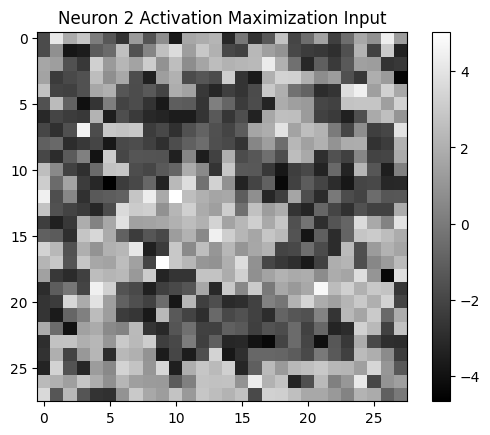

In [27]:
img = train_nth_neuron_input(n=2, iterations=4000, report_after_iteration_number_of=800)

Now if we look at weights visualization:

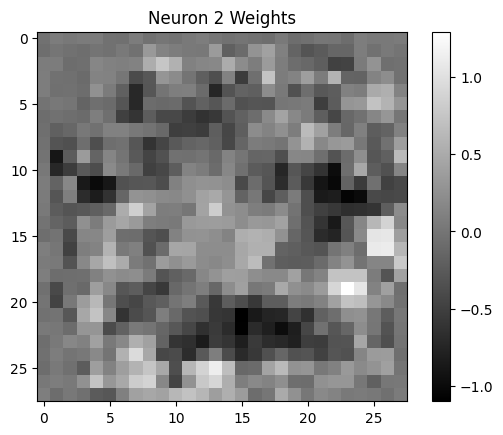

In [28]:
visualize_ith_neuron(2)

We see, that both images share common pattern - where weights are positive, training algorithm tries to train high values of pixels, so they contribute to higher activation. Vice versa, where weights are negative, the model tries to train negative values of pixels, so the resulting sum is as high as possible.